First download the image files from the enac share website

In [ ]:
# import urllib.request
# import os
# if not os.path.exists("ipeo_data.zip"):
#     print(f"downloading ipeo_data.zip")
#     urllib.request.urlretrieve('https://enacshare.epfl.ch/fQHAmeKDY6vnMxiEFRzyaP7csVXfNtg','ipeo_data.zip')

# import zipfile
# with zipfile.ZipFile("ipeo_data.zip", 'r') as zip_ref:
#     zip_ref.extractall()

Import all of the libraries that we will be using

In [1]:
%pip install pandas matplotlib
%pip install -U -q torch torchvision tqdm wget scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import pandas as pd


/Users/noemisteiger1/opt/anaconda3/envs/IPEO/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Take a look at the data splits

In [3]:
data_path = './../../ipeo_data'

train = pd.read_csv(data_path+'/splits/train.csv', header=None)
val = pd.read_csv(data_path+'/splits/val.csv', header=None)
test = pd.read_csv(data_path+'/splits/test.csv', header=None)
total = len(train) + len(val) +len(test) 


print(f'The number of train data is {len(train)}, which is {round(len(train)/total,4)*100}%')
print(f'The number of validation data is {len(val)}, which is {round(len(val)/total,4)*100}%')
print(f'The number of test data is {len(test)}, which is {round(len(test)/total,4)*100}%')

test = train.copy()
test['path'] = test.loc[:,0].apply(lambda x: data_path+'/rbg/'+x+'_rbg.tif')
test.path.tolist()

The number of train data is 7357, which is 60.0%
The number of validation data is 1225, which is 9.99%
The number of test data is 3679, which is 30.009999999999998%


['./../../ipeo_data/rbg/25566_11087_rbg.tif',
 './../../ipeo_data/rbg/25566_11088_rbg.tif',
 './../../ipeo_data/rbg/25566_11089_rbg.tif',
 './../../ipeo_data/rbg/25567_11083_rbg.tif',
 './../../ipeo_data/rbg/25567_11084_rbg.tif',
 './../../ipeo_data/rbg/25567_11085_rbg.tif',
 './../../ipeo_data/rbg/25567_11086_rbg.tif',
 './../../ipeo_data/rbg/25567_11087_rbg.tif',
 './../../ipeo_data/rbg/25567_11088_rbg.tif',
 './../../ipeo_data/rbg/25567_11089_rbg.tif',
 './../../ipeo_data/rbg/25568_11082_rbg.tif',
 './../../ipeo_data/rbg/25568_11083_rbg.tif',
 './../../ipeo_data/rbg/25568_11084_rbg.tif',
 './../../ipeo_data/rbg/25568_11085_rbg.tif',
 './../../ipeo_data/rbg/25568_11086_rbg.tif',
 './../../ipeo_data/rbg/25568_11087_rbg.tif',
 './../../ipeo_data/rbg/25568_11088_rbg.tif',
 './../../ipeo_data/rbg/25568_11089_rbg.tif',
 './../../ipeo_data/rbg/25569_11082_rbg.tif',
 './../../ipeo_data/rbg/25569_11083_rbg.tif',
 './../../ipeo_data/rbg/25569_11084_rbg.tif',
 './../../ipeo_data/rbg/25569_1108

In [4]:

class AlpineImages(Dataset):
    #mapping between labels and classes
    label_classes = {
        'rocks' : 1,
        'scree' : 2,
        'sparse rocks' : 3,
        'water' : 4,
        'glacier and permanent snow' : 5,
        'forest' : 6,
        'sparse forest' : 7,
        'grassland and others' : 8
    }

    def __init__(self, transforms = None, split = 'train', data_path='./ipeo_data'):
        self.transforms = transforms

        #grab the list of files that we need for splitting the data
        split_files = pd.read_csv(data_path+f'/splits/{split}.csv', header=None)
        #create rows that contain the values that we will use to get different images later on
        split_files['rgb_path'] = split_files.loc[:,0].apply(lambda x: data_path+'/rgb/'+x+'_rgb.tif')
        split_files['truth_path'] = split_files.loc[:,0].apply(lambda x: data_path+'/alpine_label/'+x+'_label.tif')
        #store the the columns in variables as a list
        self.data = split_files.rgb_path.dropna().tolist()
        self.truth = split_files.truth_path.dropna().tolist()
        assert len(self.data) == len(self.truth),'The truth list and the data list are not the same length'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        rgb_path = self.data[x]
        truth_path = self.truth[x]

        img_rgb = Image.open(rgb_path)
        img_truth = Image.open(truth_path)
        #set a seed so that the transforms work the same for both truths and images
        seed = np.random.randint(214567)
        np.random.seed(seed=seed)

        if self.transforms is not None:
            img_rgb = self.transforms(img_rgb)
            img_truth = self.transforms(img_truth)

        return img_rgb, img_truth


In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm
counts=np.zeros(8)
image_count=0
for i in ['train', 'test', 'val']:
    dataset=AlpineImages(data_path=data_path, split=i)
    print(f"dataset of length {len(dataset)}")
    image_count+=len(dataset)
    for j in tqdm(range(len(dataset))):
        image, label = dataset[j]
        label_arr=np.array(label)
        label_arr=np.unique(label_arr)
        for l in label_arr:
            if l == 0:
                counts[7]+=1
            else:
                counts[l-1]+=1
            

print(counts)
percents=counts/image_count*100
print(percents)


dataset of length 7357


100%|███████████████████████████████████████| 7357/7357 [01:34<00:00, 77.58it/s]


dataset of length 3679


100%|███████████████████████████████████████| 3679/3679 [00:47<00:00, 76.84it/s]


dataset of length 1225


100%|███████████████████████████████████████| 1225/1225 [00:15<00:00, 81.14it/s]

[1482. 1883.  743. 1150. 1927. 7263. 7817. 7334.]
[12.08710546 15.35763804  6.05986461  9.37933284 15.71649947 59.23660387
 63.75499551 59.81567572]


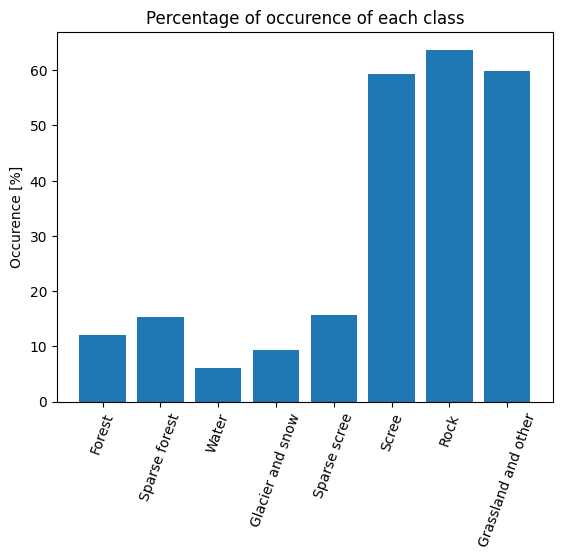

In [14]:
labels=['Forest', 'Sparse forest', 'Water', 'Glacier and snow', 'Sparse scree', 'Scree', 'Rock', 'Grassland and other']
x=[1,2,3,4,5,6,7,8]
plt.bar(x,percents)
plt.title('Percentage of occurence of each class')
plt.ylabel('Occurence [%]')
plt.xticks(x, labels, rotation=70)
plt.savefig('class_dist.jpg', bbox_inches='tight')
plt.show()

rocks (1), scree (2), sparse rocks (3), water (4), glacier and permanent snow (5), forest(6), sparse forest(7), grasslands and others (8)

Now to create the transforms

In [9]:
import torchvision.transforms as T

def get_transforms(img_size):
    transform_train = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.GaussianBlur(kernel_size=5),
            T.RandomResizedCrop(size=img_size, scale=0.75),
            T.RandomGrayscale(0.1)
    ])

    return transform_train